# This is a notebook for producing tSNE downscaled plots of Molecules produced by LSTM, PGFS and those in the filtered enamine set.

In [1]:
import os
os.chdir('../')
os.getcwd()

'/home/boto/PycharmProjects/gym-PGFS-bias'

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem

import pickle
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from gym_PGFS.chemwrapped import MolDSetDescriptorsNumpy, ChemMolFromSmilesWrapper
from sklearn.manifold import TSNE

In [ ]:
# load the preprocesed data for the reactants
with open("./data/run_A/preprocessed/reactants_processed.pkl", "rb") as f:
    enamine_reactants = pickle.load(f)
enamine_reactants.head()

In [ ]:
enamine_reactants = enamine_reactants[['smiles', 'MolD']]
enamine_reactants

In [ ]:
np_enam = np.stack(enamine_reactants['MolD'].sample(10000).tolist())
print(np_enam[0])
np_enam = np_enam.astype(float)#.iloc[0]
np_enam.dtype

In [ ]:
tisne = TSNE(n_components=2, init='random', verbose=3, n_jobs=-1)#learning_rate='auto', 
X_embed = tisne.fit_transform(np_enam)

In [ ]:
# save the tsne embedding from the reactants
with open("./data/tsne_reactants.pkl", "wb") as f:
    pickle.dump(tisne, f)

In [ ]:
# load the pickle here

In [ ]:
# load the outputs of the models
fig = plt.figure()
plt.scatter(X_embed[:, 0], X_embed[:, 1])

In [3]:
run_dirs = {'./data/run_B': 'CHEMBL3888429', 
            './data/run_A': 'CHEMBL1909140', 
            './data/run_C': 'CHEMBL1909203'}
dsets = ['CHEMBL3888429', 'CHEMBL1909140', 'CHEMBL1909203']

lstm_out = {}

for name in dsets:
    lstm_out[name] = pd.read_csv(f"./data/lstm_hc/{name}_outcome.csv")
    
# now do the same for an output of pgfs


pgfs_out = {}

for location, name in run_dirs.items():
    df = pd.read_csv(f"{location}/smiles_collected.csv")
    print(len(df))
    print(df['step'].unique()) 
    print("Picking 5")
    df = df[df['step']==5].reset_index().drop('index', 1)[['smiles', 'epoch', 'type', 'value']].sort_values(by=['type'], ascending=False).sort_values(by=['epoch'])
    pgfs_out[name] = df


# load the datasets used to train the classifiers for OS and MCS
mcs_data = {}
dcs_data = {}

## TODO: brush up/find out what exactly does my version of MolD contain 

for name in dsets:
    dcs_data[name] = pd.read_csv(f"./data/mgenfail_assays/{name}/DCS_SPLIT.csv")

for name in dsets:
    mcs_data[name] = pd.read_csv(f"./data/mgenfail_assays/{name}/MCS_SPLIT.csv")
    
    

37800
[0 1 2 3 4 5]
Picking 5
91800
[0 1 2 3 4 5]
Picking 5
91800
[0 1 2 3 4 5]
Picking 5


/tmp/ipykernel_26608/2371276863.py:21: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df[df['step']==5].reset_index().drop('index', 1)[['smiles', 'epoch', 'type', 'value']].sort_values(by=['type'], ascending=False).sort_values(by=['epoch'])


In [4]:
# compute restrict the molecule to the last epoch as well as to only one set of smiles
lstms = {}
pgfss = {}
for dataset_name in pgfs_out.keys():
    # get the lstm and pgfs datasets ( only dcs scores of the last epoch )
    lstm = lstm_out[dataset_name]
    last_lstm = lstm.epoch.max()
    lstm = lstm[(lstm['type']=='DCS_MODE')&(lstm['epoch']==last_lstm)]
    
    # compute the fingerprints
    lstm = np.stack(lstm.smiles.apply(MolDSetDescriptorsNumpy).tolist())
    
    pgfs = pgfs_out[dataset_name]
    last_pgfs = pgfs.epoch.max()
    pgfs = pgfs[(pgfs['type']=='DCS_MODE')&(pgfs['epoch']==last_pgfs)]
    
    # compute the fingerprints
    pgfs = np.stack(pgfs.smiles.apply(MolDSetDescriptorsNumpy).tolist())
    
    # now make a boxplot
    lstms[dataset_name] = lstm
    pgfss[dataset_name] = pgfs
    


In [8]:
dcss_p = {}
dcss_m = {}
mcss_p = {}
mcss_m = {}

for dataset_name in dsets:
    print(dataset_name)
    # compute the fingerprints
    dcs = dcs_data[dataset_name]
    dcs = dcs[dcs.label>0]
    print(len(dcs))
    dcs = np.stack(dcs.smiles.apply(MolDSetDescriptorsNumpy).tolist())
    
    # compute the fingerprints
    mcs = mcs_data[dataset_name]
    mcs = mcs[mcs.label>0]
    print(len(mcs))
    mcs = np.stack(mcs.smiles.apply(MolDSetDescriptorsNumpy).tolist())

    # now make a boxplot
    dcss_p[dataset_name] = dcs
    mcss_p[dataset_name] = mcs
    
    # compute the fingerprints
    dcs = dcs_data[dataset_name]
    dcs = dcs[dcs.label<1]
    print(len(dcs))
    dcs = np.stack(dcs.smiles.apply(MolDSetDescriptorsNumpy).tolist())
    
    # compute the fingerprints
    mcs = mcs_data[dataset_name]
    mcs = mcs[mcs.label<1]
    print(len(mcs))
    mcs = np.stack(mcs.smiles.apply(MolDSetDescriptorsNumpy).tolist())

    # now make a boxplot
    dcss_m[dataset_name] = dcs
    mcss_m[dataset_name] = mcs
    

CHEMBL3888429
70
70
264
263
CHEMBL1909140
29
30
392
391
CHEMBL1909203
20
20
401
401


In [ ]:
tisne = TSNE(n_components=2, init='random', verbose=3, n_jobs=-1)#learning_rate='auto', 

# merge all the data together
all_mold = np.concatenate([np_enam] + list(lstms.values()) + list(pgfss.values()) + list(dcss.values()) + list(mcss.values()))
print(all_mold.shape)
all_embed = tisne.fit_transform(all_mold)

In [ ]:
all_embed_safe = np.copy(all_embed)
# all_embed = np.copy(all_embed_safe)

In [ ]:
pgfs_e = {}
lstm_e = {}
dcs_e = {}
mcs_e = {}
training_set_mols = {}

# first take off the embedded reactants
reactants_embedded = all_embed[:10000, :]
all_embed = all_embed[10000:, :]

for src, grandpa in [[lstm_e, lstms], [pgfs_e, pgfss],
                    [dcs_e, dcss], [mcs_e, mcss]]:
    for key in dsets:
        # get the size of the original array
        sz = grandpa[key].shape[0]
        print(sz)
        # slice off and add to the dictionary and remove that piece from the stack
        src[key] = all_embed[:sz, :]
        print(src[key].shape)
        all_embed = all_embed[sz:, :]
        print(all_embed.shape)
        

In [ ]:
# fig = plt.figure(figsize=(20,20))
fig, axs = plt.subplots(1,3,figsize=(60,20))
for dataset_name, ax in zip(pgfs_out.keys(), axs):
    ax.set_xlim((-100, 100))
    ax.set_ylim((-100, 100))
    ax.set_xlabel(dataset_name)
    ax.scatter(reactants_embedded[:, 0], reactants_embedded[:, 1], label='reactants')
    ax.scatter(lstm_e[dataset_name][:, 0], lstm_e[dataset_name][:, 1], label='LSTM')
    ax.scatter(pgfs_e[dataset_name][:, 0], pgfs_e[dataset_name][:, 1], label='PGFS')
    ax.scatter(dcs_e[dataset_name][:, 0], dcs_e[dataset_name][:, 1], label='DCS')
    ax.scatter(mcs_e[dataset_name][:, 0], mcs_e[dataset_name][:, 1], label='OS-MCS')
    ax.legend()
plt.tight_layout()
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1247 samples in 0.003s...
[t-SNE] Computed neighbors for 1247 samples in 0.047s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1247
[t-SNE] Computed conditional probabilities for sample 1247 / 1247
[t-SNE] Mean sigma: 1.723237
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.226089
[t-SNE] KL divergence after 1000 iterations: 0.630087
480
(767, 2)
100
(667, 2)
70
(597, 2)
264
(333, 2)
70
(263, 2)
263
(0, 2)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1423 samples in 0.003s...
[t-SNE] Computed neighbors for 1423 samples in 0.104s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1423
[t-SNE] Computed conditional probabilities for sample 1423 / 1423
[t-SNE] Mean sigma: 1.046150
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.620674
[t-SNE] KL divergence after 1000 iterations: 0.801586
481
(942, 2)
100
(842, 2)
29
(813, 2)
392
(421, 2)
30
(391

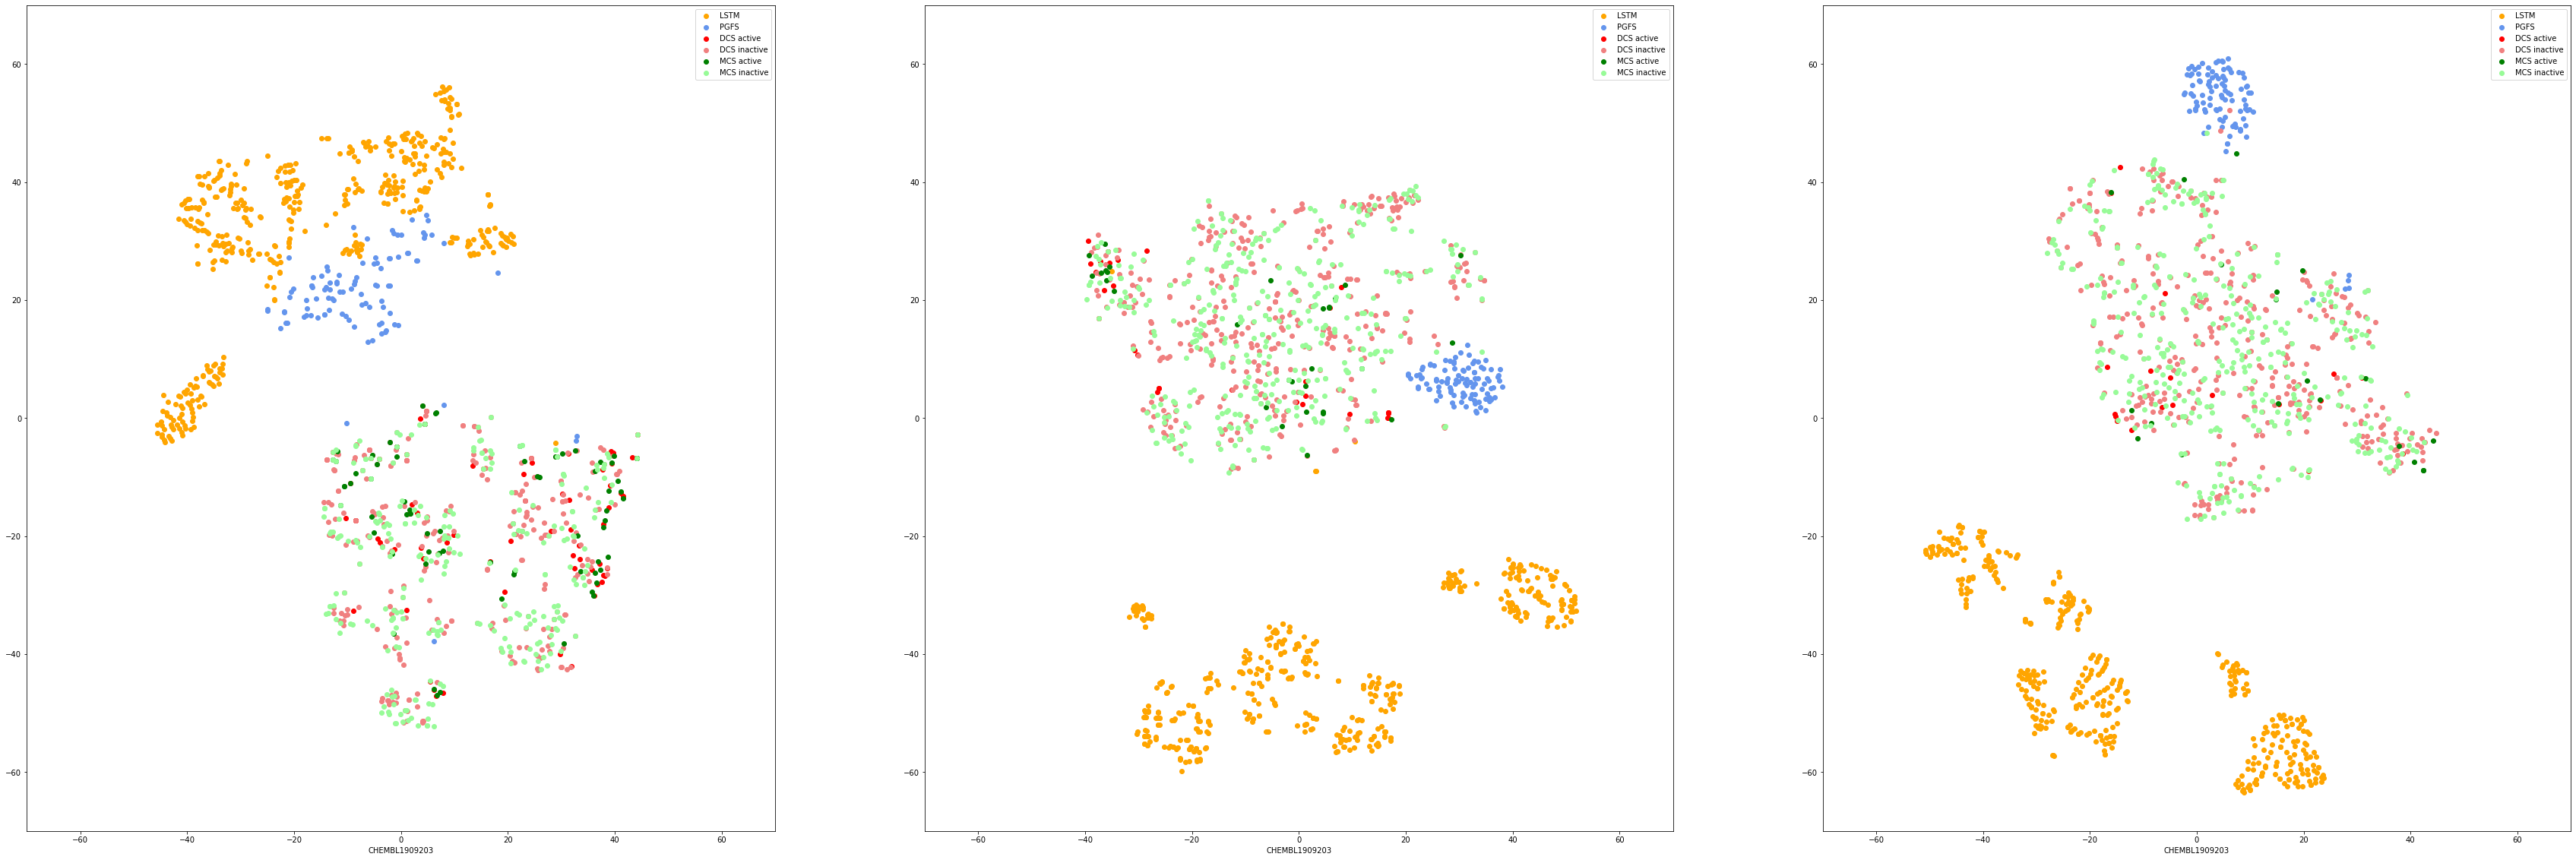

In [14]:
fig, axs = plt.subplots(1,3,figsize=(60,20))
for name, ax in zip(dsets, axs):
    tisne = TSNE(n_components=2, init='random', verbose=1, n_jobs=-1)
    
    # get all the data together from this dataset
    all_data = np.concatenate([lstms[name], pgfss[name], dcss_p[name], dcss_m[name], mcss_p[name], mcss_m[name]])
    # get rid of the molecular weight : it disrupts things
    all_data = np.delete(all_data, 4, axis=1)
    # normalize the data
    all_data = (all_data-np.mean(all_data, axis=0))/np.std(all_data, axis=0)
    
    # fit the tsne
    re_data = tisne.fit_transform(all_data)
    
    # now get the data and plot
    ax.set_xlim((-70, 70))
    ax.set_ylim((-70, 70))
    ax.set_xlabel(dataset_name)
    for src, src_label, color in [[lstms, 'LSTM', 'orange'], [pgfss, 'PGFS', 'cornflowerblue'],[dcss_p, 'DCS active', 'red'], [dcss_m, 'DCS inactive', 'lightcoral'], 
                                  [mcss_p, 'MCS active', 'green'], [mcss_m, 'MCS inactive', 'palegreen']]:
        sz = src[name].shape[0]
        print(sz)
        src_data = re_data[:sz, :]
        re_data = re_data[sz:, :]
        print(re_data.shape)
        ax.scatter(src_data[:, 0], src_data[:, 1], c=color, label=src_label)
    ax.legend()
    

In [12]:
list(pgfss.values())[0][0, :]

array([ 1.39972438e+01, -5.08332277e+00,  5.49141040e-02,  4.17385904e-02,
        7.16551000e+02,  1.05882353e+00,  1.49699274e+00,  1.13432676e+01,
        2.28008719e+01,  2.33654175e+01,  4.47816339e+01,  3.48427049e+01,
        1.65286034e+01,  1.06165652e+02,  6.17629852e+00,  5.18437039e+01,
        4.53698173e+01,  6.42082162e+00,  4.25950460e+01,  1.21327341e+01,
        2.50712738e+01,  2.18750000e-01,  8.03820000e+00,  1.29728012e+01,
        1.98087652e+01,  3.09192259e+01,  1.40953440e+01,  0.00000000e+00,
        5.28213345e+00,  3.35395964e+01,  1.01143183e+01,  8.07401327e+01,
        3.14243975e+01,  1.33573968e+01,  3.54636980e+00])

# Try the same with ECFP

In [ ]:
run_dirs = {'./data/run_B': 'CHEMBL3888429', 
            './data/run_A': 'CHEMBL1909140', 
            './data/run_C': 'CHEMBL1909203'}
dsets = ['CHEMBL3888429', 'CHEMBL1909140', 'CHEMBL1909203']

lstm_out = {}

for name in dsets:
    lstm_out[name] = pd.read_csv(f"./data/lstm_hc/{name}_outcome.csv")
    
# now do the same for an output of pgfs


pgfs_out = {}

for location, name in run_dirs.items():
    df = pd.read_csv(f"{location}/smiles_collected.csv")
    print(len(df))
    print(df['step'].unique()) 
    print("Picking 5")
    df = df[df['step']==5].reset_index().drop('index', 1)[['smiles', 'epoch', 'type', 'value']].sort_values(by=['type'], ascending=False).sort_values(by=['epoch'])
    pgfs_out[name] = df


# load the datasets used to train the classifiers for OS and MCS
mcs_data = {}
dcs_data = {}

## TODO: brush up/find out what exactly does my version of MolD contain 

for name in dsets:
    dcs_data[name] = pd.read_csv(f"./data/mgenfail_assays/{name}/DCS_SPLIT.csv")

for name in dsets:
    mcs_data[name] = pd.read_csv(f"./data/mgenfail_assays/{name}/MCS_SPLIT.csv")


In [ ]:
# compute restrict the molecule to the last epoch as well as to only one set of smiles
lstms = {}
pgfss = {}
for dataset_name in pgfs_out.keys():
    # get the lstm and pgfs datasets ( only dcs scores of the last epoch )
    lstm = lstm_out[dataset_name]
    last_lstm = lstm.epoch.max()
    lstm = lstm[(lstm['type']=='DCS_MODE')&(lstm['epoch']==last_lstm)]
    
    # compute the fingerprints
    lstm = np.stack(lstm.smiles.apply(MolDSetDescriptorsNumpy).tolist())
    
    pgfs = pgfs_out[dataset_name]
    last_pgfs = pgfs.epoch.max()
    pgfs = pgfs[(pgfs['type']=='DCS_MODE')&(pgfs['epoch']==last_pgfs)]
    
    # compute the fingerprints
    pgfs = np.stack(pgfs.smiles.apply(MolDSetDescriptorsNumpy).tolist())
    
    # now make a boxplot
    lstms[dataset_name] = lstm
    pgfss[dataset_name] = pgfs
    
dcss_p = {}
dcss_m = {}
mcss_p = {}
mcss_m = {}

for dataset_name in dsets:
    print(dataset_name)
    # compute the fingerprints
    dcs = dcs_data[dataset_name]
    dcs = dcs[dcs.label>0]
    print(len(dcs))
    dcs = np.stack(dcs.smiles.apply(MolDSetDescriptorsNumpy).tolist())
    
    # compute the fingerprints
    mcs = mcs_data[dataset_name]
    mcs = mcs[mcs.label>0]
    print(len(mcs))
    mcs = np.stack(mcs.smiles.apply(MolDSetDescriptorsNumpy).tolist())

    # now make a boxplot
    dcss_p[dataset_name] = dcs
    mcss_p[dataset_name] = mcs
    
    # compute the fingerprints
    dcs = dcs_data[dataset_name]
    dcs = dcs[dcs.label<1]
    print(len(dcs))
    dcs = np.stack(dcs.smiles.apply(MolDSetDescriptorsNumpy).tolist())
    
    # compute the fingerprints
    mcs = mcs_data[dataset_name]
    mcs = mcs[mcs.label<1]
    print(len(mcs))
    mcs = np.stack(mcs.smiles.apply(MolDSetDescriptorsNumpy).tolist())

    # now make a boxplot
    dcss_m[dataset_name] = dcs
    mcss_m[dataset_name] = mcs
    